# Image Colorization Project 
### By Daniel Mata, YingHsuan Lo, Naga Sumanth Vankadari

For this project, we decided to tackle the challenge of training a model to colorize black and white photos. For our dataset, we used this [landscape dataset from Kaggle](https://www.kaggle.com/theblackmamba31/landscape-image-colorization). For the architecture of the model, we based it on the CNN model from [this paper](https://arxiv.org/pdf/1603.08511.pdf). We will go through the code and describe the process in detail. To start, the following code demonstrates how we will be working with the LAB colorspace. The input for our model is the L channel, which is the luminance and ranges from 0-100 values. The output for our model are the ab channels, which represent different spectrum ranges (a is red-green, b is yellow-blue) with values ranging from -128-127.

In [ ]:
from keras.preprocessing.image import img_to_array, load_img
from skimage.color import lab2rgb, rgb2lab
import matplotlib.pyplot as plt
from copy import copy
import numpy as np
import matplotlib.pyplot as plt


def extract_single_dim_from_LAB_convert_to_RGB(image,idim):
    '''
    image is a single lab image of shape (None,None,3)
    '''
    z = np.zeros(image.shape)
    if idim != 0 :
        z[:,:,0]=80 ## I need brightness to plot the image along 1st or 2nd axis
    z[:,:,idim] = image[:,:,idim]
    z = lab2rgb(z)
    return(z)

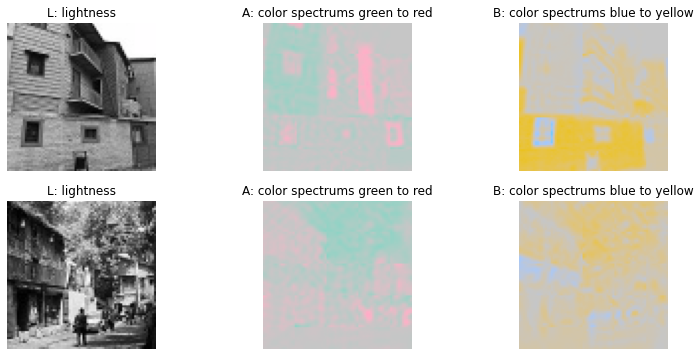

In [ ]:

sample_img = [r"/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Image Colorization/1.jpg",
              r"/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Image Colorization/88.jpg"]
target_size = (75,75)
# Get images
Ximg = []
for filename in sample_img:
    Ximg.append(load_img(filename,target_size=target_size))

Xsub_rgb = []
for img in Ximg:    
    Xsub_rgb.append(img_to_array(img)) 

Xsub_rgb = np.array(Xsub_rgb)
Nsample = Xsub_rgb.shape[0]
Xsub_rgb01 = Xsub_rgb/255.0
Xsub_lab = rgb2lab(Xsub_rgb01)
sub_lab_rgb = np.zeros( Xsub_lab.shape)
Xsub_lab_rgb = np.zeros( Xsub_lab.shape)

lab_rgb_gray = extract_single_dim_from_LAB_convert_to_RGB(Xsub_lab[1],0)
lab_rgb_gray = extract_single_dim_from_LAB_convert_to_RGB(Xsub_lab[1],1)
lab_rgb_gray = extract_single_dim_from_LAB_convert_to_RGB(Xsub_lab[1],2) 

count = 1
fig = plt.figure(figsize=(13,3*Nsample))
for lab in Xsub_lab:
    
    ax = fig.add_subplot(Nsample,3,count)
    lab_rgb_gray = extract_single_dim_from_LAB_convert_to_RGB(lab,0) 
    ax.imshow(lab_rgb_gray); ax.axis("off")
    ax.set_title("L: lightness")
    count += 1
    
    ax = fig.add_subplot(Nsample,3,count)
    lab_rgb_gray = extract_single_dim_from_LAB_convert_to_RGB(lab,1) 
    ax.imshow(lab_rgb_gray); ax.axis("off")
    ax.set_title("A: color spectrums green to red")
    count += 1
    
    ax = fig.add_subplot(Nsample,3,count)
    lab_rgb_gray = extract_single_dim_from_LAB_convert_to_RGB(lab,2) 
    ax.imshow(lab_rgb_gray); ax.axis("off")
    ax.set_title("B: color spectrums blue to yellow")
    count += 1
plt.show()

## Preprocessing
We begin by first processing our images using keras preprocessing and numpy. **Note that this was done locally rather than on the cloud as this proved to be the more efficient/faster method** Our images are separated into 3 different folders: 'train', 'valid', and 'test' with variations of the original images (45, 90, 180, 270 degree image rotations). Since we are using the LAB colorspace to train the model, we only utilize the photos that already have color (the extracted L channels are the X inputs and the ab channels are our Y inputs). Using ImageDataGenerator, we rescale our images' RGB values from 0-255 to 0-1. Following this, we convert from RGB to Lab colorspace, and then renormalize. Finally, we save our data as numpy files in order to upload to Google Drive.

As a sidenote, one of our many struggles involved the image processing. We first started by using OpenCV but when training our model, our final colorized image contained extreme colors that made no sense and after doing some research, it seemed like there was an issue converting from OpenCV image data to Tensorflow image data. Thus, we followed [this video](https://www.youtube.com/watch?v=EujccFRio7o&ab_channel=DigitalSreeni) in which they used keras preprocessing and were able to get more "normal" results.

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2lab

train_path = "C:/Users/dm0469/Documents/Deep Learning/Image Colorization/colorization/train/"
val_path = "C:/Users/dm0469/Documents/Deep Learning/Image Colorization/colorization/valid/"
test_path = "C:/Users/dm0469/Documents/Deep Learning/Image Colorization/colorization/test/"

def preprocessing(path, batch):

    # Iterate through all the data
    train_datagen = ImageDataGenerator(rescale=1./255)
    train = train_datagen.flow_from_directory(directory=path,
    target_size=(75,75),
    batch_size=batch,
    class_mode=None)

    # Separate L and ab channels
    X = []
    Y = []
    for img in train[0]:
        try:
            img = io.imread('image.jpg')
            lab = rgb2lab(img)
            X.append(lab[:,:,0] / 100)    # Normalize L channel
            Y.append(lab[:,:,1:] / 128)     # Normalize ab channels
        except:
            print('error')

    X = np.array(X)
    Y = np.array(Y)
    X= X.reshape(X.shape+(1,)) # (75, 75, 1) --> (1, 75, 75, 1)

    # print(X.shape)
    # print(Y.shape)

    return X, Y


L_train, ab_train = preprocessing(train_path, 25670)
L_val, ab_val = preprocessing(val_path, 2850)
L_test, ab_test = preprocessing(test_path, 7120)

# Verifying final shapes/values
print("TRAIN\n")
print(L_train.shape, '*'*20, ab_train.shape, sep='\n')
print(L_train.min(), L_train.max())
print(ab_train.min(), ab_train.max(), '\n')

print("VAL\n")
print(L_val.shape, '*'*20, ab_val.shape, sep='\n')
print(L_val.min(), L_val.max())
print(ab_val.min(), ab_val.max(), '\n')

print("TEST\n")
print(L_test.shape, '*'*20, ab_test.shape, sep='\n')
print(L_test.min(), L_test.max())
print(ab_test.min(), ab_test.max())

# Store to upload to google drive
np.save('L_train', L_train)
np.save('ab_train', ab_train)
np.save('L_val', L_val)
np.save('ab_val', ab_val)
np.save('L_test', L_test)
np.save('ab_test', ab_test)

## Working in Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!unzip -u "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Image Colorization/new_image_data.zip" -d "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Image Colorization"

Archive:  /content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Image Colorization/new_image_data.zip
  inflating: /content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Image Colorization/ab_test.npy  
  inflating: /content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Image Colorization/ab_train.npy  
  inflating: /content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Image Colorization/ab_val.npy  
  inflating: /content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Image Colorization/L_test.npy  
  inflating: /content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Image Colorization/L_train.npy  
  inflating: /content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Image Colorization/L_val.npy  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

path = r"/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Image Colorization/"

## Loading Data and Training Our Model

Here, we finally load our data and begin training our model.


In [ ]:
# Load training data
L_train = np.load(path + "L_train.npy") / 100
ab_train = np.load(path + "ab_train.npy")

# Load validation data
L_val = np.load(path + "L_val.npy") / 100
ab_val = np.load(path + "ab_val.npy")

# Load test data
L_test = np.load(path + "L_test.npy") / 100
ab_test = np.load(path + "ab_test.npy")

In [ ]:
print("Train Data",
      L_train.shape, ab_train.shape,
      "Validation Data",
      L_val.shape, ab_val.shape,
      "Test data",
      L_test.shape, ab_test.shape,
      sep='\n'
      )

Train Data
(25670, 75, 75, 1)
(25670, 75, 75, 2)
Validation Data
(2850, 75, 75, 1)
(2850, 75, 75, 2)
Test data
(7120, 75, 75, 1)
(7120, 75, 75, 2)


Our model consists of several blocks of CNNs based on the paper mentioned above. However, we converted from PyTorch to TensorFlow code and tweaked a couple of parameters in order to better suit our process. More specifically, we changed our input shape, adjusted padding/strides such the output matched the target data, and switched from a final SoftMax activation to a Tanh, given that we normalized our values to be from -1-1 rather than 0-1 (like in the original paper). Moreover, we used an adam optimizer with a slow learning rate, early stopping, and RMSE and the metric. Overall, our model was a regression task that differed from the paper in which they treated the problem as a classification task.

In [ ]:
model = models.Sequential()

# First block of CNNs
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(2, (3,3), activation='relu', input_shape=(77,77,1)))
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(64, (3,3), strides=2, activation='relu'))
model.add(layers.BatchNormalization())

# Second block of CNNs
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(128, (3, 3), strides=2, activation='relu'))
model.add(layers.BatchNormalization())

# # Third block of CNNs
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(256, (3, 3), strides=2, activation='relu'))
model.add(layers.BatchNormalization())

# # Fourth block of CNNs
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())

# Fifth block of CNNs
model.add(layers.ZeroPadding2D(2))
model.add(layers.Conv2D(512, (3, 3), dilation_rate=2, activation='relu'))
model.add(layers.ZeroPadding2D(2))
model.add(layers.Conv2D(512, (3, 3), dilation_rate=2, activation='relu'))
model.add(layers.ZeroPadding2D(2))
model.add(layers.Conv2D(512, (3, 3), dilation_rate=2, activation='relu'))
model.add(layers.BatchNormalization())

# Sixth block of CNNs
model.add(layers.ZeroPadding2D(2))
model.add(layers.Conv2D(512, (3, 3), dilation_rate=2, activation='relu'))
model.add(layers.ZeroPadding2D(2))
model.add(layers.Conv2D(512, (3, 3), dilation_rate=2, activation='relu'))
model.add(layers.ZeroPadding2D(2))
model.add(layers.Conv2D(512, (3, 3), dilation_rate=2, activation='relu'))
model.add(layers.BatchNormalization())

# # Seventh block of CNNs
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())

# Eighth block of CNNs
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2DTranspose(256, (3,3), strides=2, activation='relu'))
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.ZeroPadding2D(1))
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.Conv2D(313, (1,1), dilation_rate=1))
model.add(layers.Conv2D(2, (1,1), dilation_rate=1, activation='tanh'))
model.add(layers.UpSampling2D(3, interpolation='bilinear'))

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=2,
        verbose=1,
    )
]

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile(optimizer=opt, loss='mse', metrics='RootMeanSquaredError')

history = model.fit(x=L_train, y=ab_train, validation_data=(L_val, ab_val), batch_size=100, callbacks=callbacks, epochs=20)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_88 (ZeroPaddi (None, 77, 77, 1)         0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 75, 75, 2)         20        
_________________________________________________________________
zero_padding2d_89 (ZeroPaddi (None, 77, 77, 2)         0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 38, 38, 64)        1216      
_________________________________________________________________
batch_normalization_28 (Batc (None, 38, 38, 64)        256       
_________________________________________________________________
zero_padding2d_90 (ZeroPaddi (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 38, 38, 128)      

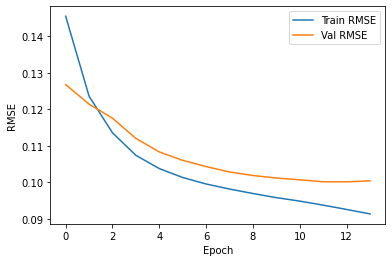

In [ ]:
# Plot metrics
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label = 'Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Final model evaluation
model.evaluate(L_test, ab_test)

223/223 [==============================] - 8s 37ms/step - loss: 0.5396 - root_mean_squared_error: 0.7346


[0.5395779013633728, 0.7345593571662903]

### This is for saving/loading the model

In [ ]:
# We saved the best model in a previous session
model.save(path + '/my_model_1.h5')

In [ ]:
# Load model instead of training
model = tf.keras.models.load_model(path + 'my_model_1.h5')


## Make some predictions

Above, we decided to save our best performing model and just load it back in once we ran another Google Colab session. From here, will displaying some of the best and worst images, followed by some other images that we believed looked great in the Observations section.

In [ ]:
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imshow

def individual_comparison(index, predictions):
  '''
  Plots the prediction vs the ground truth image
  index - index of image to compare
  predictions - list of predictions to get index from
  '''

  fig = plt.figure(figsize=(12, 10))

  # Adds subplot on position 1
  ax1 = fig.add_subplot(121)
  # Adds subplot on position 2
  ax2 = fig.add_subplot(122)

  # Create Prediction shape
  result = np.zeros((75,75,3))
  result[:,:,0] = L_test[index][:,:,0] * 100
  result[:,:,1:] = predictions[index] * 128

  # Create ground truth shape
  real = np.zeros((75,75,3))
  real[:,:,0] = L_test[index][:,:,0] * 100
  real[:,:,1:] = ab_test[index] * 128

  # Visualize predicted vs ground truth
  ax1.set_title("Predicted")
  ax1.imshow(lab2rgb(result))

  ax2.set_title("Ground Truth")
  ax2.imshow(lab2rgb(real))

  return


def prediction_vs_target(index, predictions):
  '''
  Returns prediction and target data in final
  Lab colorspace form.
  index - index of image to compare
  predictions - list of predictions to get index from
  '''

  prediction = np.zeros((75,75,3))
  prediction[:,:,0] = L_test[index][:,:,0] * 100
  prediction[:,:,1:] = predictions[index] * 128

  target = np.zeros((75,75,3))
  target[:,:,0] = L_test[index][:,:,0] * 100
  target[:,:,1:] = ab_test[index] * 128

  return prediction, target


def plot_10(metric_indices, ab_predictions, best=True):
  '''
  Plots 10 prediction-groundtruth pairs within a single figure
  metric_indices - list of indices of image pairs to plot
  ab_predictions - list of image predictions
  best - if True, title will be "Best Images", other wise "Worst Images"
  '''

  COLUMNS = 4
  ROWS = 5

  comparisons = []

  for i in range(10):
    predict, targ = prediction_vs_target(metric_indices[i], ab_predictions)
    comparisons.append(predict)
    comparisons.append(targ)

  fig=plt.figure(figsize=(15,15))
  plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  plt.axis('off')
  if best:
    plt.title("Best Images", pad=15, fontsize=15)

  else:
    plt.title("Worst Images", pad=15, fontsize=15)

  for i in range(1, COLUMNS*ROWS +1):
    fig.add_subplot(ROWS, COLUMNS, i)
    plt.imshow(lab2rgb(comparisons[i-1]))
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    if i % 2 != 0:
      plt.title("Predicted")

    else:
      plt.title("Target")

  plt.show()

def rmse_per_instance(predictions, target):
  '''
  Returns the RMSE on a per-instance basis
  predictions - list of predictions
  target - list of groundtruth
  '''
  
  rmse_list = np.array([np.sum(np.sqrt(np.square(predictions[x][:,:,0] - target[x][:,:,0])/ 5625)) \
                          for x in range(len(predictions))
                          ])

  worst_imgs = np.argpartition(rmse_list, -10)[-10:]
  best_imgs = np.argpartition(rmse_list, 10)[:10]

  return best_imgs, worst_imgs
  
  

In [ ]:
# Save predictions for displaying images
ab_prediction = model.predict(L_test)

print(ab_prediction.shape) # (7120, 75, 75, 1)

# Get indices of best and worst predictions
model_best, model_worst = rmse_per_instance(ab_prediction, ab_test)

(7120, 75, 75, 2)


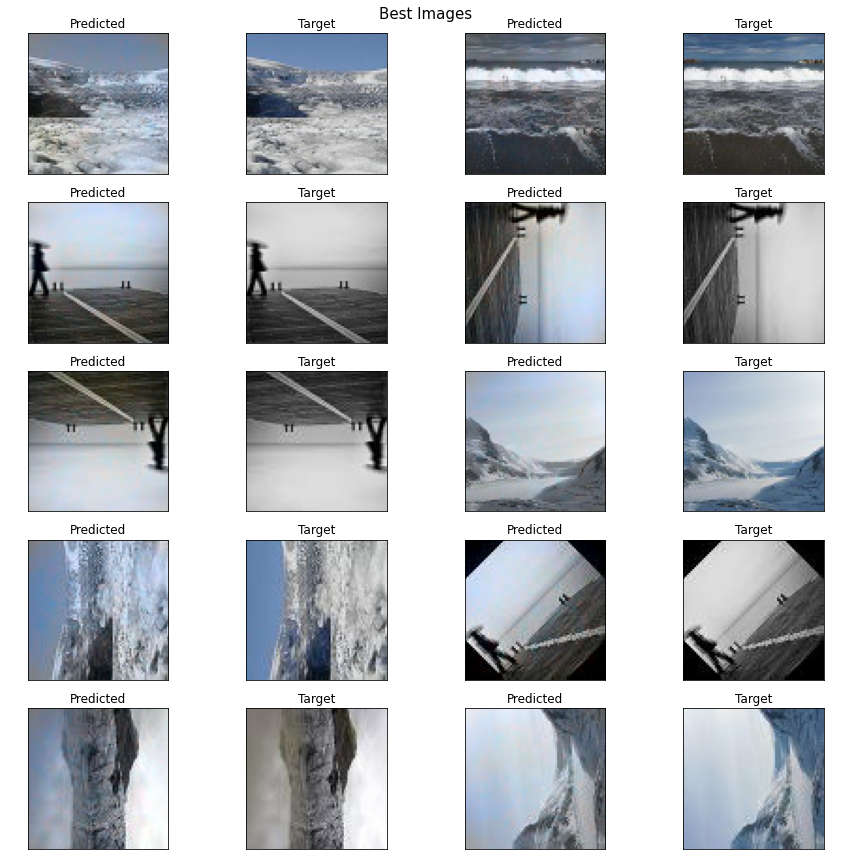

In [ ]:
# Best Deep Learning
plot_10(model_best, ab_prediction)

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


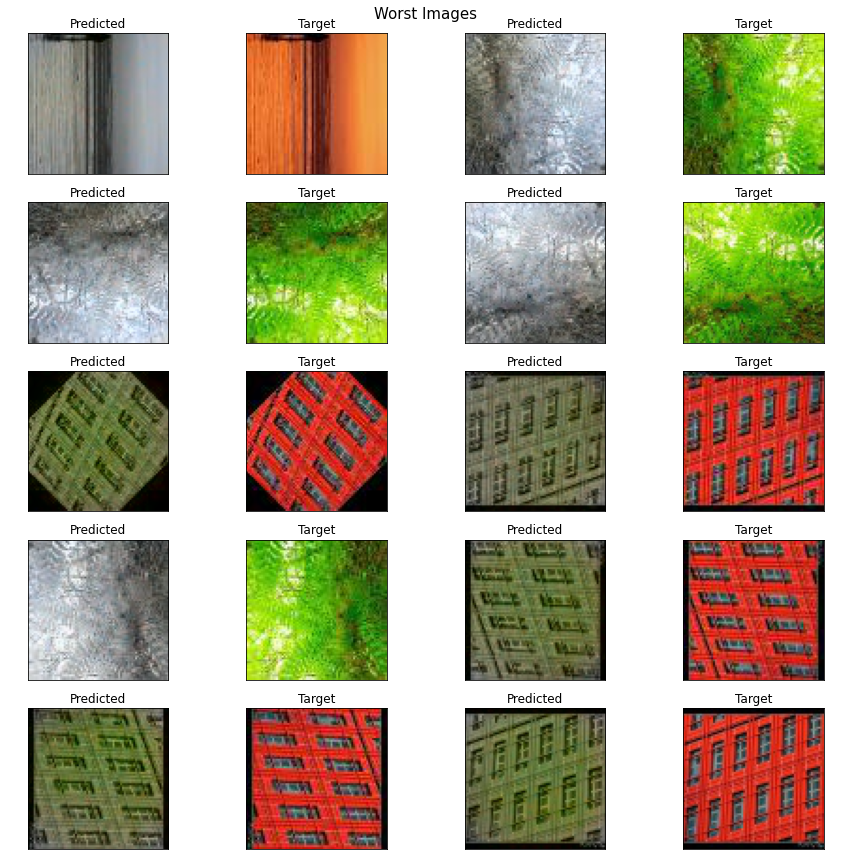

In [ ]:
# Worst Deep Learning
plot_10(model_worst, ab_prediction, False)

# Linear Regression

In [ ]:
# Reshaped for Linear Regression
L_train_reshaped = L_train.reshape(len(L_train),75*75)
ab_train_reshaped = ab_train.reshape(len(ab_train),75*75*2)

print(L_train_reshaped.shape,
      ab_train_reshaped.shape)

(25670, 5625) (25670, 11250)


In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(L_train_reshaped, ab_train_reshaped)

In [ ]:
# Reshape Test for Linear Regression
L_test_reshaped = L_test.reshape(len(L_test),75*75)

# Make predictions
ab_prediction_lin_reg = lin_reg.predict(L_test_reshaped)

# Reshape linear regressions predictions back to ab channel shape
ab_prediction_lr_final = ab_prediction_lin_reg.reshape([7120, 75, 75,2])

ab_prediction_lr_final.shape

(7120, 75, 75, 2)

In [ ]:
# Using TensorFlow RMSE method on Sklearn model
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(y_true, y_pred)))

root_mean_squared_error(ab_test, ab_prediction_lr_final)

<tf.Tensor: shape=(), dtype=float32, numpy=0.11825592>

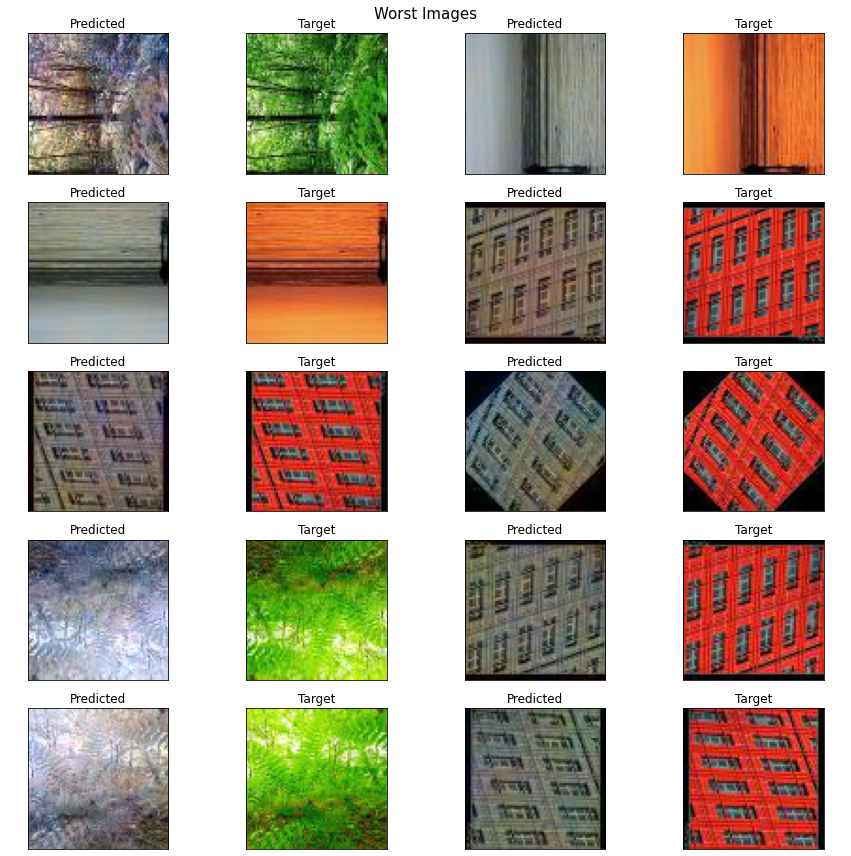

In [ ]:
# Best and worst image indices
lr_best, lr_worst = rmse_per_instance(ab_prediction_lr_final, ab_test)

# Worst Linear Regression
plot_10(lr_worst, ab_prediction_lr_final, False)

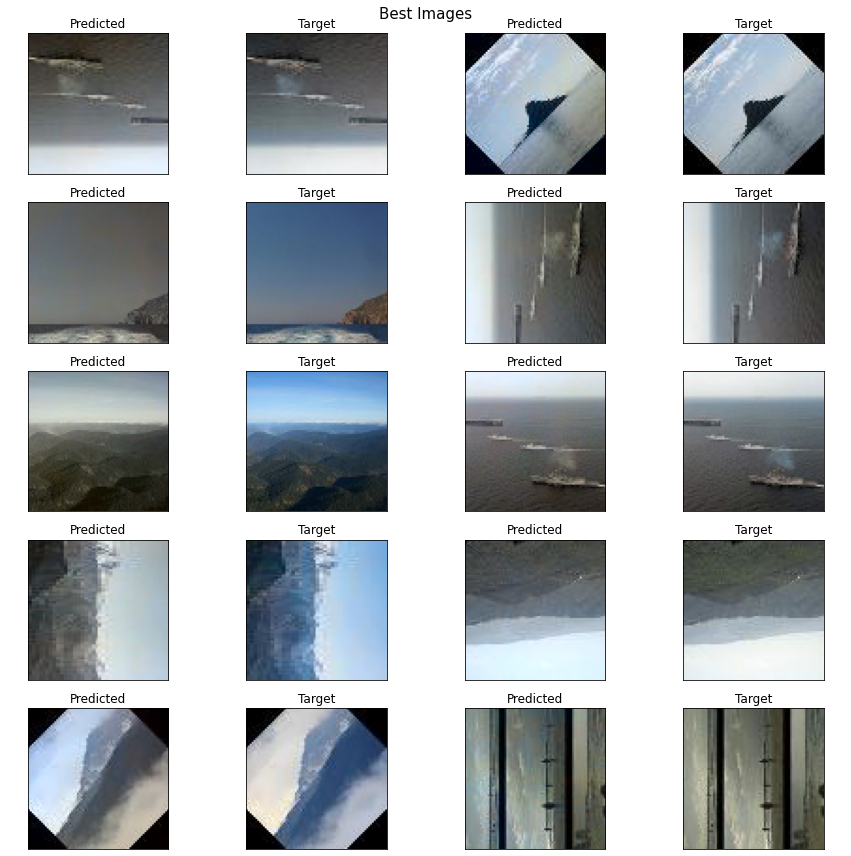

In [ ]:
# Best Linear Regression
plot_10(lr_best, ab_prediction_lr_final)

## Results

**The image below is an example of what is fed into the models.

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


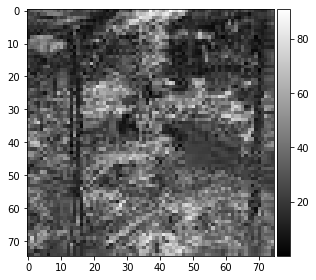

In [ ]:
imshow(L_test[340][:,:,0] * 100, cmap='gray')

In terms of the RMSE metric, our DL model did not perform as well as the baseline model. With a score of _0.11825592_, the baseline Linear Regression model outperformed the DL model's score of
_0.7345593571662903_. However, we think the RMSE metric might not be the best method for evaluating our models for a couple of reasons:
1.  Some of the image predictions from our DL model looked better to us than the regression when it came to predicting green, vivid colors (like the images below). 
2. The top 10 images from each model were images that consisted of mainly neutral colors (rather than vivid reds, blues, or greens). This allowed for a lower RMSE score given that the models did not do well in predicting vivid colors anyways.
3. In the original paper that we followed, Richard Zhang treated this problem as a classification task rather than a regression task. The paper describes how low ab values with desaturated colors would be favored when using a simple metric such as the L2 loss (or in our case, the RMSE metric). We purposely chose to treat the task as a regression problem in order to investigate the impact of such a model. The top ten images in both models actually demonstrates what was described in the paper. You can see how *all* images are of low ab-value, desaturated colors. 

#### Green Images

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


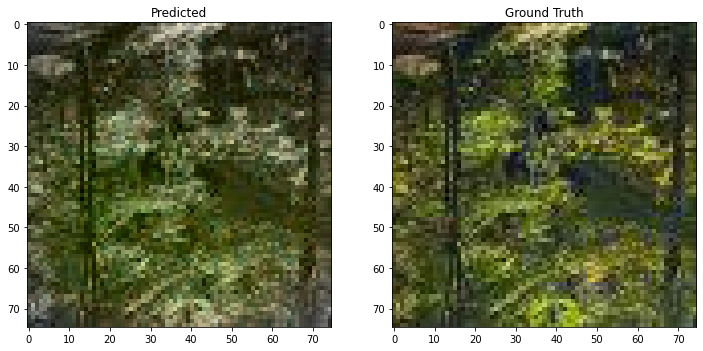

In [ ]:
# Deep Learning Model Prediction
individual_comparison(340, ab_prediction)

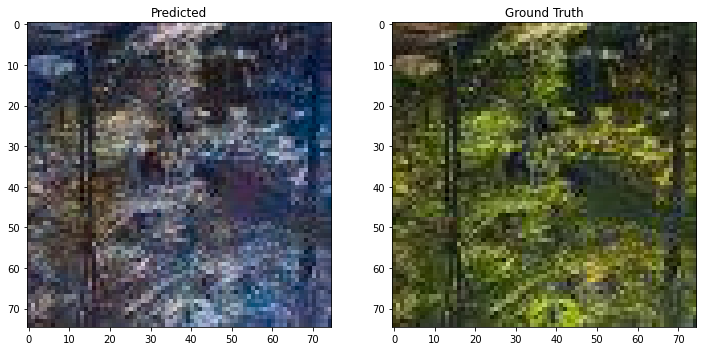

In [ ]:
# Linear Regression Model Prediction
individual_comparison(340, ab_prediction_lr_final)

#### Blue Images

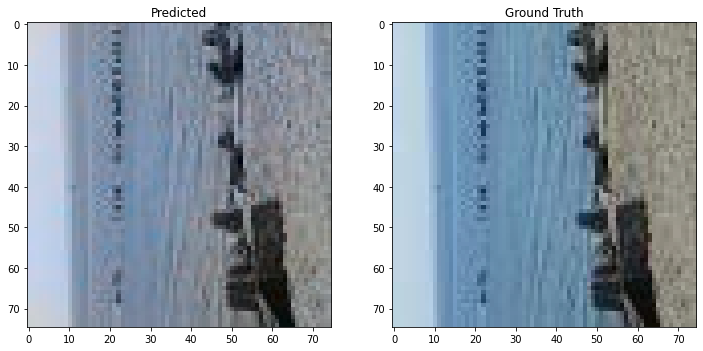

In [ ]:
# Deep Learning Model Prediction
individual_comparison(503, ab_prediction)

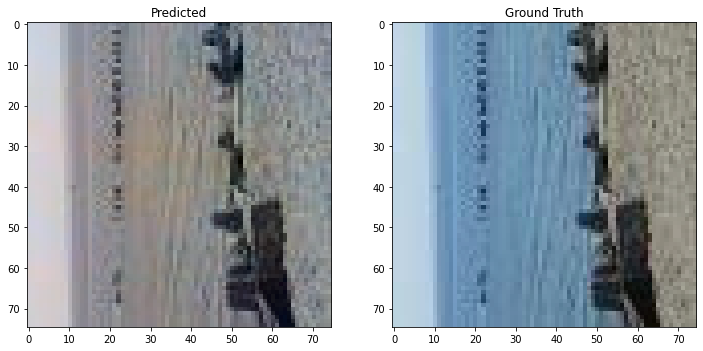

In [ ]:
# Linear Regression Model Prediction
individual_comparison(503, ab_prediction_lr_final)

#### Red Images

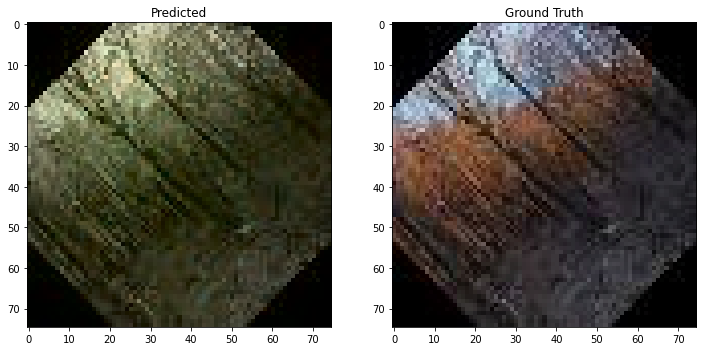

In [ ]:
# Deep Learning Model Prediction
individual_comparison(550, ab_prediction)

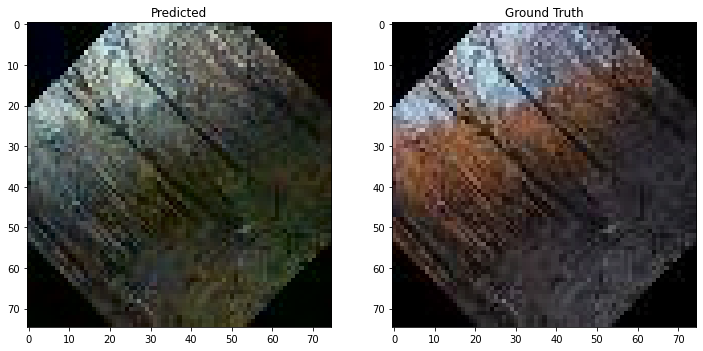

In [ ]:
# Linear Regression Model Prediction
individual_comparison(550, ab_prediction_lr_final)

There were a couple more observations that we noticed.
1. when it comes to images with red, our deep learning model tend to confused red with green whereas our linear regression model was still predicting desaturated blueish-greenish colors.

2. Even though our colors were sometimes very off, both models were still recognizing the shapes and structures within the images.

3. Although our models can recognize these shapes and structures, they still confine to the subject matter (in our case landscape images). For example, we tried to colorize human faces and it did not work as well compared to the landscape images.

## Resources

[Our Proposal](https://docs.google.com/document/d/1JYjURVdeDiOWo0t_AT9qb0_ubRk-RIUu99E6ZzaJAKM/edit#heading=h.svg9nox9mjda)

[Image Colorization Research Paper](https://arxiv.org/pdf/1603.08511.pdf)

[Keras Preprocessing Tutorial](https://www.youtube.com/watch?v=EujccFRio7o&ab_channel=DigitalSreeni)

[LAB colorspace](https://en.wikipedia.org/wiki/CIELAB_color_space)

[Landscape Dataset](https://www.kaggle.com/theblackmamba31/landscape-image-colorization)
